# Santander Kaggle

Ok! Let's try the Santander Kaggle! https://www.kaggle.com/c/santander-customer-satisfaction/data

In [49]:
%matplotlib inline
print "Let's get started"
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)
import os
import pandas as pd

Let's get started


Let's load our data

In [50]:
def read_csv(fname,max_rows=None,labeled=None):
    curr_file=open(fname,'rU')
    curr_read=csv.reader(curr_file)
    if max_rows:
        df=pd.read_csv(fname, sep=',',header=0,nrows=max_rows)
    else:
        df=pd.read_csv(fname, sep=',',header=0)
    if labeled:
        df_data= df[range(len(df.columns.values)-1)]
        df_label= df[[-1]]
        return df_data,df_label
    else:
        return df



#train_data,train_label=read_csv('train.csv',max_rows=10000,labeled=True) 
train_data,train_label=read_csv('train.csv',labeled=True) 

# https://www.kaggle.com/cast42/santander-customer-satisfaction/exploring-features
# remove placeholder value
train_data = train_data.replace(-999999,2) 
test_data=read_csv('test.csv')

How many positive instances do we have?

In [51]:
print np.mean(train_label.values)

0.0395685345962


Not a lot :(

## Data cleaning

The next two data processing steps I copied from [here](https://www.kaggle.com/yuansun/santander-customer-satisfaction/lb-0-84-for-starters/code)

First let's remove columns with no variance

In [52]:
to_remove=[]
for col in train_data.columns:
    if train_data[col].std()==0:
        to_remove.append(col)

print len(to_remove)

train_data.drop(to_remove, axis=1, inplace=True)
test_data.drop(to_remove, axis=1, inplace=True)
    

34


And then duplicate columns

In [53]:
to_remove = []
c = train_data.columns
for i in range(len(c)-1):
    v = train_data[c[i]].values
    for j in range(i+1,len(c)):
        if np.array_equal(v,train_data[c[j]].values):
            to_remove.append(c[j])

print len(to_remove)

train_data.drop(to_remove, axis=1, inplace=True)
test_data.drop(to_remove, axis=1, inplace=True)            

29


Let's check how many columns this leaves us with

In [54]:
len(train_data.columns)

307

## Parameter visualization

Let's try to get a better intuition of how our data looks by plotting out some raw histograms

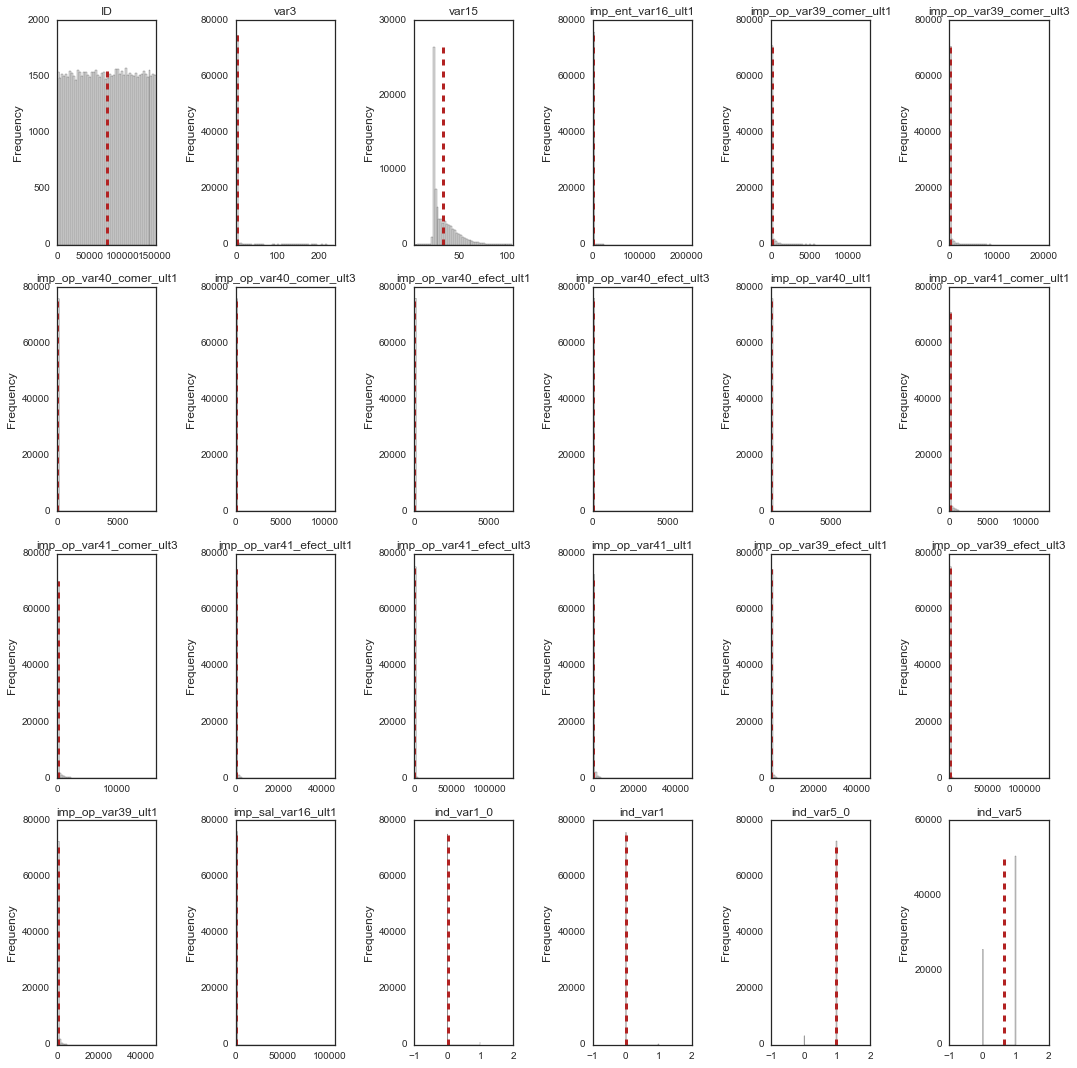

In [55]:
plt.figure(figsize=(15,15))
for icol,count in enumerate(range(1,25)):

    ax_curr=plt.subplot(4, 6, count)

    curr_data=train_data.values[:,icol]
    n, bins, patches = plt.hist(curr_data, 50, facecolor='lightgrey', alpha=0.75)

    # add a mean line
    mean_val=np.mean(curr_data)
    l = plt.plot([mean_val,mean_val], [0,np.max(n)+10], 'b--', linewidth=3,c='firebrick')

    plt.title(train_data.columns.values[icol],fontsize='12')
    plt.ylabel('Frequency',fontsize='12')
    ax_curr.set_xlim([np.min(curr_data)-1, np.max(curr_data)+1])
    plt.locator_params(nbins=4)

plt.tight_layout()
plt.show()

Andddd the data is really weird. Some things have super skewed exponential-ish distributions, others are binomial with really either no or virtually no positive occurences. Given the very small number of successful interactions, there may be a lot of information in these tails/rare events...

# First pass: SVM

Let's start off with an SVM

In [56]:
from sklearn import svm
from sklearn.cross_validation import train_test_split
from sklearn import metrics 

print 'Splitting data'

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

print 'Fitting SVM'

clf = svm.SVC(probability=True)
clf.fit(X_train, y_train['TARGET'].values)  

print('Overall AUC:', metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Splitting data
Fitting SVM
('Overall AUC:', 0.48076186676100841)


# More data processing: Oversampling

We may be able to get those small examples better by oversampling our data (we have 150,000 samples, around 3%--4500-- of which will be positive). This might be ok? [This page](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/) had some helpful suggestions. I'm going to try uniform sampling (I tried to find a working SMOTE sampler but I think it was being weird with Pandas). 

This function will do the oversampling

In [57]:
def oversample(X_train,y_train):
    print 'Oversampling'

    # Oversample the training examples and fit
    train_pos=X_train.iloc[[i[0] for i in y_train.values==1]]
    train_neg=X_train.iloc[[i[0] for i in y_train.values==0]]

    over_data=train_pos.sample(n=len(y_train)/2,replace=True).\
        append(train_neg.sample(n=len(y_train)/2,replace=True))
    over_label=[1]*(len(y_train)/2)+[0]*(len(y_train)/2)
    
    return over_data,over_label

Let's see how this works now

In [58]:
print 'Splitting data'

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

over_data,over_label=oversample(X_train,y_train)

print 'Fitting SVM'

clf = svm.SVC(probability=True)
clf.fit(over_data, over_label)  

print('Overall AUC:', metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Splitting data
Oversampling
Fitting SVM
('Overall AUC:', 0.49159605272150547)


A ~.008 improvement! x.X

# Feature engineering?

Before we try a more complex model, I'd like to try some feature engineering. It looks like [the other noobs haven't had much luck](https://www.kaggle.com/c/santander-customer-satisfaction/forums/t/19818/feature-engineering-how-to) (as of 4/2/2016).

First, let's try a PCA and see if this gets rid of any correlated features and what not.

In [59]:
from sklearn.decomposition import PCA

print 'Try 10 factors...'
pca_trial = PCA(n_components=10) 
pca_trial.fit(train_data)
print(pca_trial.explained_variance_ratio_) 

print '\n'

print '7 seems good'
pca = PCA(n_components=7) 
pca_data_list=pca.fit_transform(train_data)
pca_data=pd.DataFrame.from_records(pca_data_list)

Try 10 factors...
[ 0.65933419  0.16274096  0.07265493  0.0378346   0.03361263  0.01634353
  0.00465604  0.00320719  0.00268279  0.00179026]


7 seems good


In [60]:
print 'Splitting data'

X_train, X_test, y_train, y_test = train_test_split(pca_data, train_label, test_size=0.33, random_state=42)

over_data,over_label=oversample(X_train,y_train)

print 'Fitting SVM'

clf = svm.SVC(probability=True)
clf.fit(over_data, over_label)  

print('Overall AUC:', metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

Splitting data
Oversampling
Fitting SVM
('Overall AUC:', 0.59590832767148694)


Ok, that's more like it! Finally a substantial improvement!

# Decision Tree

A decision tree might be able to better capture the small number of poor customer interactions

In [61]:
from sklearn import tree

X_train, X_test, y_train, y_test = train_test_split(pca_data, train_label, test_size=0.33, random_state=42)

tree_auc=[]
for md in range(1,25):
    clf = tree.DecisionTreeClassifier(max_depth=md)
    clf.fit(X_train, y_train)  
    tree_auc.append((md,metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])))

#    # oversampling doesn't appear to be helping this
#     print 'With oversampling'
#     over_data,over_label=oversample(X_train,y_train)
#     clf = tree.DecisionTreeClassifier(max_depth=md)
#     clf.fit(over_data, over_label)  
#     print('Overall AUC:', metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    
tree_df=pd.DataFrame(tree_auc)
best_depth=tree_df.ix[tree_df[1].idxmax()]

print 'Best Depth'
print best_depth

Best Depth
0    6.00000
1    0.60193
Name: 5, dtype: float64


Ok, a small improvement.

# Gradient Boosted Decision Tree

Let's try to get some more power by boosting this tree with PCA

In [62]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(pca_data, train_label, test_size=0.33, random_state=42)

gbd=pd.DataFrame(columns=('n_est', 'lr','depth','auc'))

for ie in range(1,5):
    for lr in np.linspace(.1,2,5):
        for dt in range(1,5):
            clf = GradientBoostingClassifier(n_estimators=ie, learning_rate=lr,\
                                             max_depth=dt)
            clf.fit(X_train, y_train['TARGET'].values)
            auc=metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            new_data=pd.DataFrame([[ie,lr,dt,auc]],columns=('n_est', 'lr','depth', 'auc'))
            gbd=gbd.append(new_data)
        
print gbd.head()        

   n_est     lr  depth       auc
0      1  0.100      1  0.570153
0      1  0.100      2  0.593421
0      1  0.100      3  0.597347
0      1  0.100      4  0.600759
0      1  0.575      1  0.570153


In [63]:
best_param = gbd.iloc[gbd['auc'].values.argmax()]

print 'Best Params'
print best_param

Best Params
n_est    4.000
lr       1.525
depth    3.000
auc      0.605
Name: 0, dtype: float64


Let's check how it is without PCA

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

gbd=pd.DataFrame(columns=('n_est', 'lr','depth','auc'))

for ie in [int(ii) for ii in np.linspace(100,300,3)]:
    for lr in np.linspace(.05,.15,3):
        for dt in range(1,3):
            clf = GradientBoostingClassifier(n_estimators=ie, learning_rate=lr,\
                                             max_depth=dt)
            clf.fit(X_train, y_train['TARGET'].values)
            auc=metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            new_data=pd.DataFrame([[ie,lr,dt,auc]],columns=('n_est', 'lr','depth', 'auc'))
            gbd=gbd.append(new_data)
        
print gbd.head()  

   n_est    lr  depth       auc
0    100  0.10      1  0.814912
0    100  0.10      2  0.823394
0    100  1.05      1  0.814804
0    100  1.05      2  0.805973
0    100  2.00      1  0.802675


In [68]:
gbd

,n_est,lr,depth,auc
0,100,0.10,1,0.814912
0,100,0.10,2,0.823394
0,100,1.05,1,0.814804
0,100,1.05,2,0.805973
0,100,2.00,1,0.802675
0,100,2.00,2,0.730035
0,200,0.10,1,0.820338
0,200,0.10,2,0.824521
0,200,1.05,1,0.815288
0,200,1.05,2,0.801541


In [69]:
best_param = gbd.iloc[gbd['auc'].values.argmax()]

print 'Best Params'
print best_param

Best Params
n_est    200.000000
lr         0.100000
depth      2.000000
auc        0.824521
Name: 0, dtype: float64


Hmmm so our current PCA is losing some information. Maybe increasing the number of components will help?

In [ ]:
%%time
from sklearn.decomposition import PCA

print 'try 200'
pca = PCA(n_components=200) 
pca_data_list=pca.fit_transform(train_data)
pca_data=pd.DataFrame.from_records(pca_data_list)

X_train, X_test, y_train, y_test = train_test_split(pca_data, train_label, test_size=0.33, random_state=42)

gbd=pd.DataFrame(columns=('n_est', 'lr','depth','auc'))

for ie in [int(ii) for ii in np.linspace(150,250,4)]:
    for lr in np.linspace(.02,.1,4):
        for dt in range(1,4):
            clf = GradientBoostingClassifier(n_estimators=ie, learning_rate=lr,\
                                             max_depth=dt)
            clf.fit(X_train, y_train['TARGET'].values)
            auc=metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
            new_data=pd.DataFrame([[ie,lr,dt,auc]],columns=('n_est', 'lr','depth', 'auc'))
            print new_data
            gbd=gbd.append(new_data)


try 200


In [77]:
best_param = gbd.iloc[gbd['auc'].values.argmax()]

print 'Best Params'
print best_param

Best Params
n_est    200.000000
lr         0.046667
depth      3.000000
auc        0.819475
Name: 0, dtype: float64


# XGBOOST

[All these posts](https://www.kaggle.com/yuansun/santander-customer-satisfaction/lb-0-84-for-starters/code) keep trying this XGBoost function. Let's see how it does.

In [ ]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM

X_train, X_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.33, random_state=42)

clf = xgb.XGBClassifier(missing=np.nan, max_depth=5, n_estimators=350, \
                        learning_rate=0.03, nthread=4, subsample=0.95, colsample_bytree=0.85, seed=4242)
clf.fit(X_train, y_train['TARGET'].values)
auc=metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])

print auc

# Submission

In [ ]:
id_test = test_data['ID']
test_pred=clf.predict(test_data)
submission = pd.DataFrame({"ID":id_test, "TARGET":y_pred})
submission.to_csv("submission.csv", index=False)
print 'Complete'